https://github.com/Z-Zheng/ChangeOS

In [2]:
# changeos has four APIs
# (e.g., 'list_available_models', 'from_name', 'visualize', 'demo_data')
import changeos
import matplotlib.pyplot as plt

In [3]:
import rasterio as rio
import geopandas as gpd
import fiona
import os
import pickle
# enable kml file reading for geopandas
from shapely.geometry import box, Polygon
import pandas as pd
import numpy as np
import leafmap.foliumap as leafmap # use folium backend
import rioxarray as rioxr
import matplotlib.pyplot as plt
from typing import List, Union, Dict
from pathlib import Path
fiona.drvsupport.supported_drivers['KML'] = 'rw'

pd.options.display.max_columns = 50

In [4]:
CRS = 32629

In [5]:
project_path = os.path.expanduser("/home/rustt/Documents/Projects/building_damage")

In [6]:
out_dir_path = os.path.join(project_path, "Data/processed")
raw_data_path = os.path.join(project_path, "Data/raw")

In [7]:
def make_path(file_name, *path):
    return os.path.join(*path, file_name)

def save_pickle(data, output_path):
    with open(output_path, 'wb') as f:
        pickle.dump(data, f)
        
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [8]:
town_test = "Tafeghaghte"
date_event = '2023-09-09'

In [9]:
# town = gpd.read_file(town_loc_path, driver='KML').to_crs(CRS)
# town.columns = [_.lower() for _ in town.columns]
# town = town.rename({"name":"town_name"}, axis=1).drop("description", axis=1)
# town["geometry"] = gpd.GeoSeries(gpd.points_from_xy(x=town.geometry.x, y=town.geometry.y))
# town.to_file(make_path("marocco_town.shp", raw_data_path))
town = gpd.read_file(make_path("marocco_town.shp", raw_data_path))

### Change on repo example

In [2]:
# constructing ChangeOS model
# support 'changeos_r18', 'changeos_r34', 'changeos_r50', 'changeos_r101'
model = changeos.from_name('changeos_r18') # take 'changeos_r101' as example


Downloading: "https://github.com/Z-Zheng/ChangeOS/releases/download/v0.2/changeos_r18.pt" to /home/rustt/.cache/torch/hub/checkpoints/changeos_r18.pt
24.2%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

92.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [3]:
# load your data or our prepared demo data
# numpy array of shape [1024, 1024, 3], [1024, 1024, 3]
pre_disaster_image, post_disaster_image = changeos.demo_data()

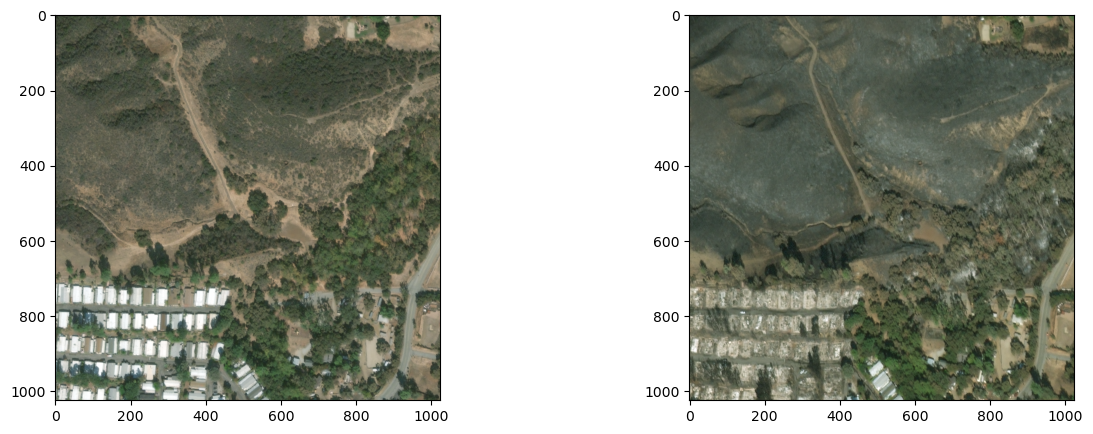

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(pre_disaster_image)
axes[1].imshow(post_disaster_image)

In [11]:

# model inference
loc, dam = model(pre_disaster_image, post_disaster_image)

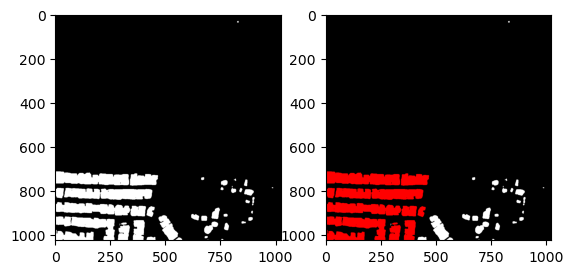

In [12]:

# put color map on raw prediction
loc, dam = changeos.visualize(loc, dam)

# visualize by matplotlib
plt.subplot(121)
plt.imshow(loc)
plt.subplot(122)
plt.imshow(dam)
plt.show()

### Change on maxar images

In [25]:
name = "Tafeghaghte"

In [26]:
def list_file_dir(*path):
    dir = os.path.join(*path)
    return [os.path.join(dir, _) for _ in os.listdir(dir)]

In [27]:
after_list = [_ for _ in list_file_dir(out_dir_path, name, "after") if _.endswith(".tif")]
before_list = [_ for _ in list_file_dir(out_dir_path, name, "before") if _.endswith(".tif")]

In [28]:
after_list

['/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/after/10300100ED11EA00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/after/10300500E4F92300-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/after/crop_256_10300100ED11EA00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/after/crop_128_10300100ED11EA00-visual.tif']

In [29]:
sorted(before_list)

['/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/10400100405FEB00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/10400100405FEB00-visual_reproOTB.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/1040010045AE4B00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/10400100797DAC00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/crop_10400100405FEB00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/crop_128_10400100405FEB00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/crop_128_crop_256_10400100405FEB00-visual.tif',
 '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/crop_256_10400100405FEB00-visual.tif',
 '/home/rustt/Documents/Projects/building_dama

In [32]:
def crop_rs_on_shape(rs_path: str, shape: Union[Polygon, List], out_path: str):
    """
    Crop raster from shapely geometry shape

    - add check crs equality
    - clip_box with rioxarray => pyproj CRS error
    
    """
    if not isinstance(shape, list):
        shape = [shape]
        
    with rio.open(rs_path) as src:
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        out_meta = src.meta
    
        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    
        with rio.open(out_path, "w", **out_meta) as dest:
            dest.write(out_image)

In [33]:
def get_crop_center_box(rs_path, out_path, l_side=256):
    with rio.open(rs_path) as src:
        bbox_coords  = (
            src.bounds.left, 
            src.bounds.bottom,
            src.bounds.right,
            src.bounds.top,
        )
        centroid = gpd.GeoDataFrame(geometry=[box(*bbox_coords)], crs=CRS).centroid 

    bbox = box(*centroid.buffer(l_side/(2*0.34)).total_bounds)
    
    crop_rs_on_shape(rs_path, bbox, out_path)
    return bbox

In [34]:
# easier : try to crop on pixels sizes/ number

In [35]:
l_side = [64, 128, 256, 512, 768, 1024, 1280, 1536]

crop_rs = {}

for size in l_side:
    
    crop_rs[size] = {}
    
    for img_path, temp in zip([before_list, after_list], ["before", "after"]): 
        
    

        """
        
        out_path = make_path(f"crop_{size}_{Path(img_path[0]).stem}.tif", 
                             out_dir_path, 
                             name, 
                             temp)

        res = get_crop_center_box(img_path[0], 
                                  out_path=out_path, 
                                  l_side=size)

        """
        # take the first img for now
        img_path = sorted(img_path)
        rs_arr = rioxr.open_rasterio(img_path[1]).data        
        crop_rs[size][temp] = rs_arr[:, 
                                (rs_arr.shape[1] // 2) - (size//2):(rs_arr.shape[1] // 2) + (size//2), 
                                (rs_arr.shape[2] // 2) - (size//2):(rs_arr.shape[2] // 2) + (size//2), 
                                    ]
        

In [49]:
import skimage.io as io

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


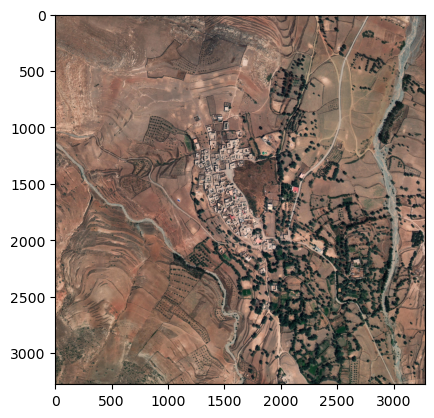

In [53]:
plt.imshow(img_before.data.transpose(1,2,0) / 255, cmap="grey")

<Axes: >

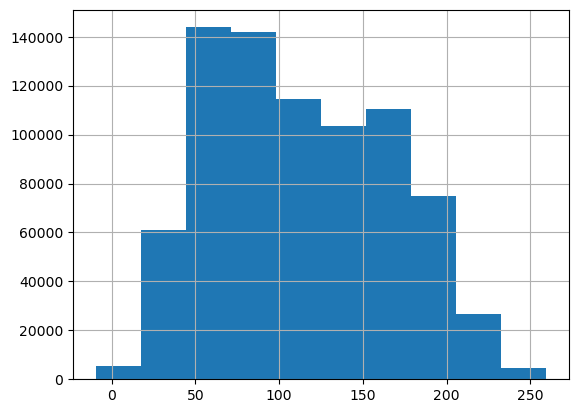

In [48]:
pd.Series(crop_rs[512]["before"].flatten()).hist()

#### Apply changeos

In [36]:
# constructing ChangeOS model
# support 'changeos_r18', 'changeos_r34', 'changeos_r50', 'changeos_r101'
model = changeos.from_name('changeos_r50') # take 'changeos_r101' as example

```python
l_side = 128
pre_path = make_path(f"crop_{l_side}_10400100405FEB00-visual.tif", out_dir_path, name, "before")
post_path = make_path(f"crop_{l_side}_10300100ED11EA00-visual.tif", out_dir_path, name, "after")

pre_img = rioxr.open_rasterio(pre_path).data.transpose(1, 2, 0)
post_img = rioxr.open_rasterio(post_path).data.transpose(1, 2, 0)
```

In [39]:
img_repro = '/home/rustt/Documents/Projects/building_damage/Data/processed/Tafeghaghte/before/10400100405FEB00-visual_reproOTB.tif'
img_before = rioxr.open_rasterio(img_repro)

In [42]:
img_before.sel(band=1).data

array([[101.81599 , 147.47873 , 147.91524 , ..., 111.01609 , 102.43076 ,
         95.54556 ],
       [108.80597 , 139.89465 , 124.86033 , ..., 109.26218 , 105.894196,
         98.94488 ],
       [126.06702 , 118.480995,  83.85411 , ..., 113.05553 , 112.0046  ,
        104.58478 ],
       ...,
       [142.70943 , 137.20103 , 157.53523 , ..., 105.39315 , 104.277245,
         95.41273 ],
       [159.33458 , 101.65272 , 118.14686 , ..., 116.83728 , 115.39814 ,
        109.14795 ],
       [ 49.13185 ,  24.959332,  27.355091, ...,  34.556107,  34.65448 ,
         34.457565]], dtype=float32)

https://stackoverflow.com/questions/69027829/how-to-add-row-titles-to-the-following-the-matplotlib-code

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


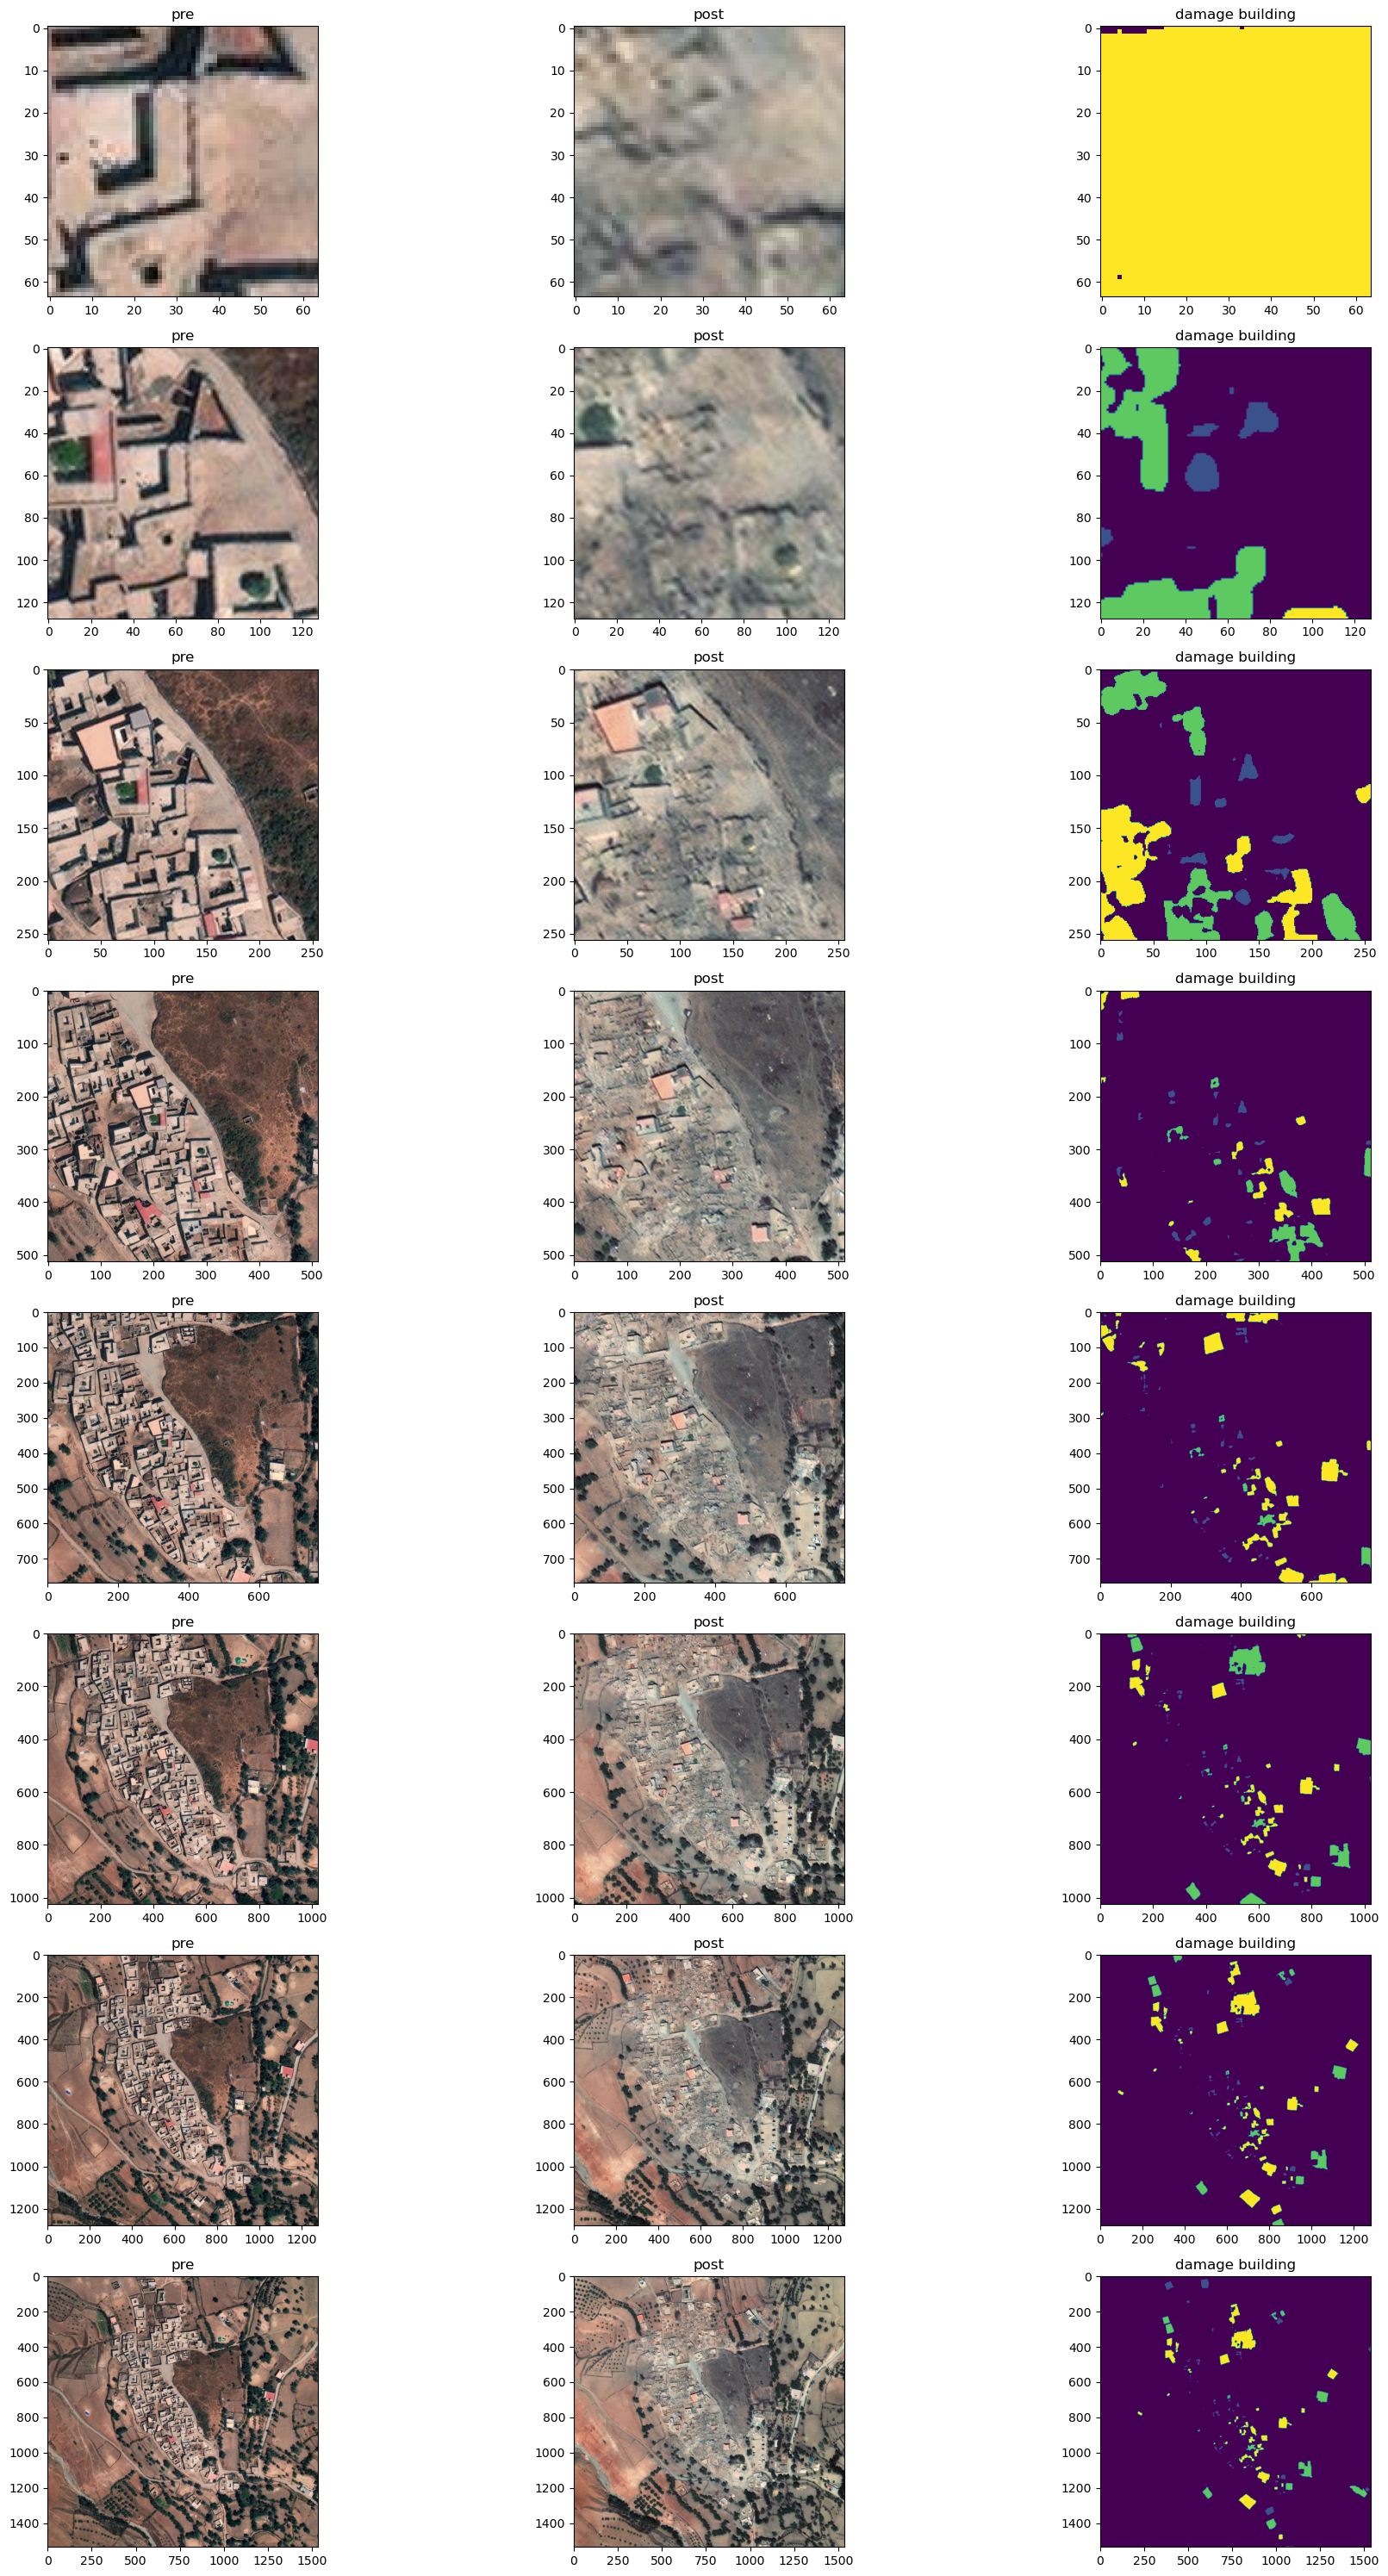

In [54]:
n_col = 3
fig, axes = plt.subplots(len(l_side), n_col, figsize=(20, 30))
axes = axes.ravel()
l_side = [64, 128, 256, 512, 768, 1024, 1280, 1536]
n_curr=0

for i, size in enumerate(l_side):
        
    pre_img = crop_rs[size]["before"].transpose(1, 2,  0)
    post_img = crop_rs[size]["after"].transpose(1, 2,  0)
    
    loc, dam = model(pre_img, post_img)
    
    for ii, name, img in zip(range(n_curr, n_curr+n_col), ["pre", "post", "damage building"], [pre_img/255, post_img, dam]):
        axes[ii].imshow(img)
        axes[ii].set_title(name)
    n_curr+=n_col
plt.tight_layout()

In [60]:
np.expand_dims(dam, axis=0).shape

(1, 512, 512)

### 128 size

In [26]:
l_side = 128
pre_img = crop_rs[l_side]["before"].transpose(1, 2,  0)
post_img = crop_rs[l_side]["after"].transpose(1, 2,  0)

In [30]:
print(pre_img.shape)

(256, 256, 3)


In [27]:
loc, dam = model(pre_img, post_img)

In [28]:
pd.Series(dam.flatten()).value_counts()

0    50140
3     5385
4     5157
1     4854
Name: count, dtype: int64

Text(0.5, 1.0, 'before event')

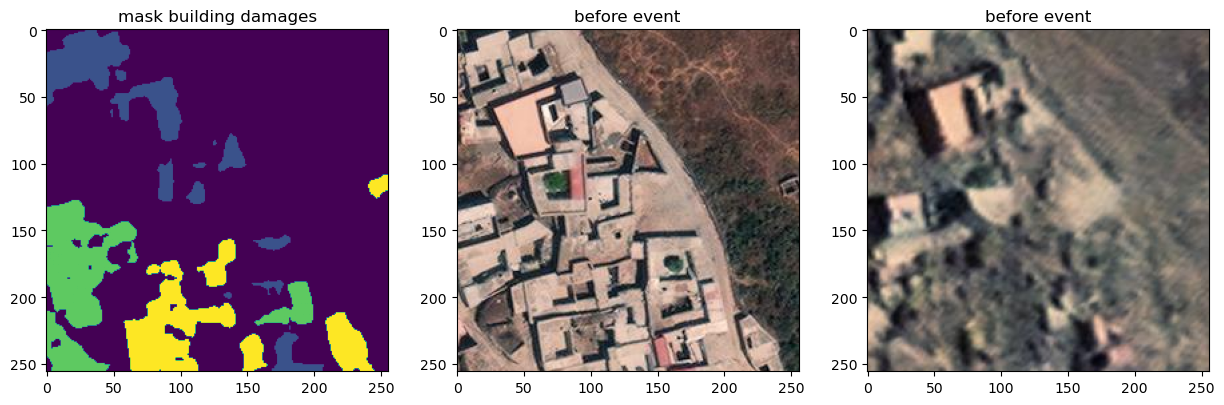

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(dam)
axes[0].set_title("mask building damages")
axes[1].imshow(pre_img)
axes[1].set_title("before event")
axes[2].imshow(post_img)
axes[2].set_title("before event")

### 256 size

In [31]:
l_side = 256
pre_img = crop_rs[l_side]["before"].transpose(1, 2,  0)
post_img = crop_rs[l_side]["after"].transpose(1, 2,  0)

In [33]:
print(pre_img.shape)

(512, 512, 3)


In [34]:
loc, dam = model(pre_img, post_img)

In [35]:
pd.Series(dam.flatten()).value_counts()

0    248073
4      9449
1      4108
3       514
Name: count, dtype: int64

Text(0.5, 1.0, 'before event')

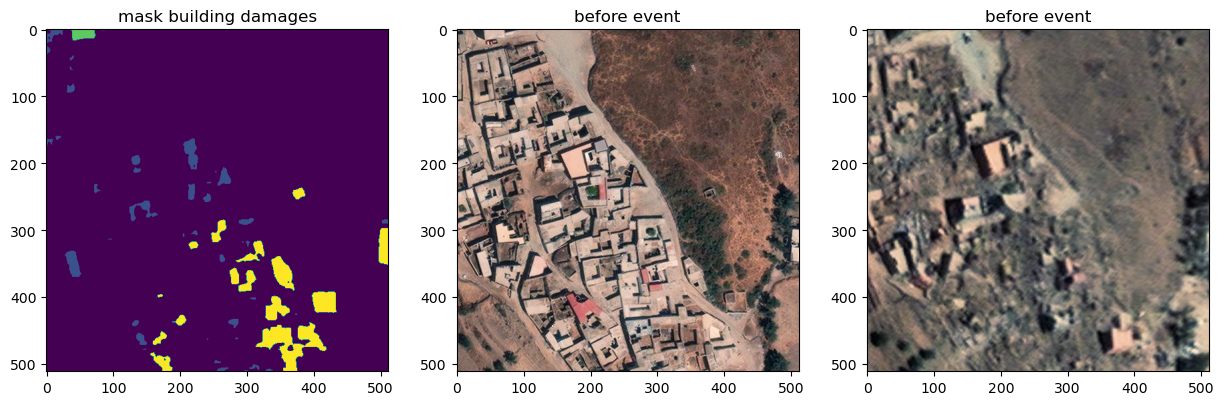

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(dam)
axes[0].set_title("mask building damages")
axes[1].imshow(pre_img)
axes[1].set_title("before event")
axes[2].imshow(post_img)
axes[2].set_title("before event")

* try on different sensor
* try on different scale

### Try on same sensor